In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import tqdm

import seaborn as sns
from fitter import Fitter
import scipy.stats
from scipy.stats import exponnorm, erlang, gennorm
from empirical_distribution import EmpiricalDistribution
import util
import dtaidistance.dtw
from dtaidistance import dtw_visualisation as dtwvis

from skmultiflow.drift_detection import PageHinkley
from driftwatch import GreedyKS, IksReservoir, ReservoirSampling, LallDDSketch

experiments = [
    [{'file_column': 'Logits_Negative', 'days_range': (22,23), 'months_range': (1,2), 'hours_range': (0,24)},
      {'dist_type': 'fit','n_bins': 3000, 'testing': True},
      ],
    [{'file_column': 'Logits_Negative', 'days_range': (22,23), 'months_range': (1,2), 'hours_range': (0,24)},
      {'dist_type': 'empirical','n_bins': 3000, 'testing': True},
      ]
]

In [27]:
results = {}
for e in experiments:
    stream_ln, tweets_per_file = util.load_data(**e[0])
    d_type = e[1]['dist_type']
    args = (e[1]['n_bins'], tweets_per_file, d_type, e[1]['testing'])
    # methods_drifts, methods_times = util.run(args)
    results[d_type] = util.run(args)
    
filename = f'../results/detect_drifts_{int(time.time())}.pkl'
pd.to_pickle(results, filename)
print(filename)

100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


Number of tweets processed:  36333


100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Number of tweets processed:  36333


100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Number of tweets processed:  36333


100%|██████████| 24/24 [00:21<00:00,  1.12it/s]

Number of tweets processed:  36333
../results/detect_drifts_1682186760.pkl


In [3]:
results = pd.read_pickle('../results/detect_drifts_1682186760.pkl')

results_times = {}
results_drifts = {}
dtw_dist_vs_minibatch = {}
dtw_fit_vs_empirical = {}

for exp_type in results:
    results_drifts[exp_type] = results[exp_type][0]
    results_times[exp_type] = results[exp_type][1]

    dtw_dist_vs_minibatch[exp_type] = {k:dtaidistance.dtw.distance(results_drifts[exp_type].get(k, []), results_drifts[exp_type]['mini-batch'])
                                       for k in util.approx_methods}


dtw_fit_vs_empirical = {'DTW - Fit vs Empirical':
                          {k:dtaidistance.dtw.distance(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, []))
                                for k in results_drifts['fit'].keys() if k != 'Page Hinkley'},
                        'qtd drifts Fit':
                          {k:len(results_drifts['fit'][k]) for k in results_drifts['fit'].keys() if k != 'Page Hinkley'},
                        'qtd drifts Empirical':
                          {k:len(results_drifts['empirical'][k]) for k in results_drifts['fit'].keys() if k != 'Page Hinkley'}
                        }


In [6]:
# pd.DataFrame({'empirical': results_drifts['empirical']['Reservoir Sampling'], 'fit': results_drifts['fit']['Reservoir Sampling'][:19]})
# len(results_drifts['fit']['Reservoir Sampling'][:19])

# pd.DataFrame([results_dtw['fit']], columns=list(results_dtw['fit'].keys()))


In [9]:
display(pd.DataFrame(results_times))

display(pd.DataFrame(dtw_fit_vs_empirical))

display(pd.DataFrame(dtw_dist_vs_minibatch))

,fit,empirical
Page Hinkley,0.039717,0.034917
GreedyKS,0.769145,1.004891
Reservoir Sampling,0.738374,3.114991
IKS + RS,0.435609,2.579841


,DTW - Fit vs Empirical,qtd drifts Fit,qtd drifts Empirical
GreedyKS,999.496373,20,20
Reservoir Sampling,1006.949850,20,20
IKS + RS,3589.449819,19,20
mini-batch,371.818504,21,21


,fit,empirical
Page Hinkley,5965.281050,5935.063100
GreedyKS,295.577401,923.641705
Reservoir Sampling,235.588625,923.607601
IKS + RS,435.518082,3600.222632


GreedyKS
Reservoir Sampling
IKS + RS
mini-batch


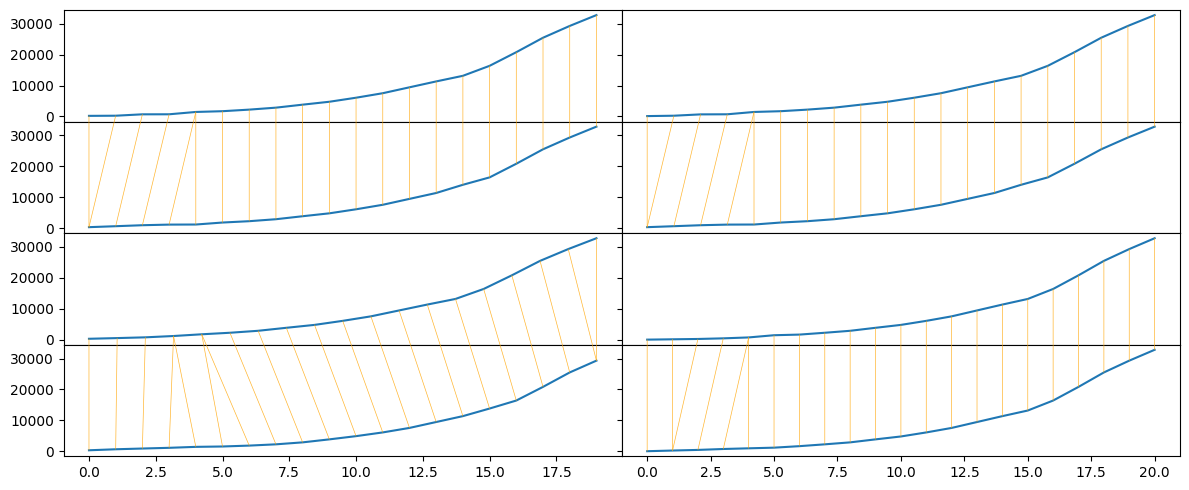

In [145]:
f_vs_e = [(results_drifts['fit'].get(k, []), results_drifts['empirical'].get(k, [])) for k in results_drifts['fit'].keys() if k != 'Page Hinkley']

figg, axss = plt.subplots(4, 2, figsize=(12,5), sharey=True, gridspec_kw={'hspace':0.0, 'wspace':0.0})

for i,k in enumerate(results_drifts['fit'].keys()):
    if k == 'Page Hinkley':
        continue
    s1 = np.array(results_drifts['fit'].get(k, []))
    s2 = np.array(results_drifts['empirical'].get(k, []))

    print(k)
    if i == 3 or i == 4:
        init = 2
    else:
        init = 0

    path = dtaidistance.dtw.warping_path(s1, s2)
    fig, axs = dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axss.T[(i-1)%2][init:])
    # fig, axs = dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axss.T[i-1])
    # fig, axs = dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axss.T[i-1][2:])
    # fig, axs = dtwvis.plot_warping(s1, s2, path, fig=figg, axs=axss.T[i][2:])
    # break

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U18'), dtype('<U18')) -> None

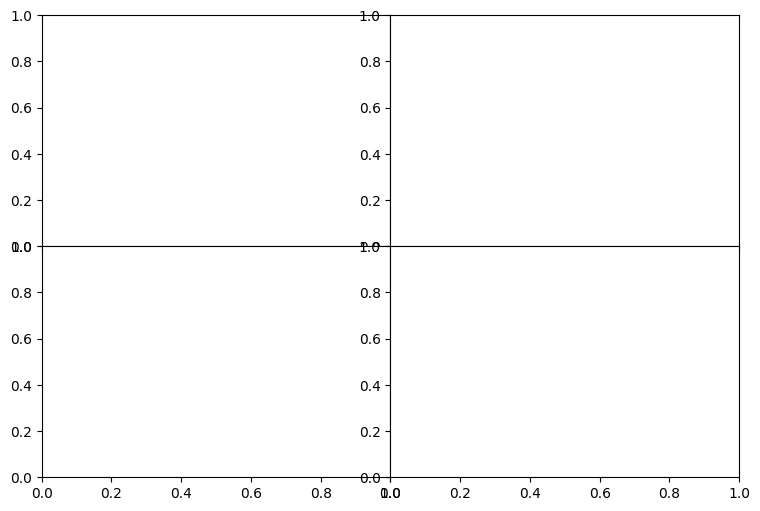

In [23]:
axes_prop_cycle = {
    'markersize':[8]*20,
    'linewidth':[1]*20,
    'markevery': [8]*20,
    'marker':['o', 'X', 's', 'P', 'D']*4,
    'color':sns.color_palette("Set1", 20)
}

def show_results(results, axs, d_type, legend=False):
    bps = axs[0].boxplot(results, vert=False, patch_artist=True)
    axs[0].set_xscale('log')
    axs[0].grid(axis='x')
    axs[0].set_title(r'Distribution type: ' + d_type)
    axs[0].set_yticklabels([])
    
    for i, j, k, l in zip(bps['boxes'], bps['medians'], axes_prop_cycle['marker'][3::-1], axes_prop_cycle['color']):
        i.set_facecolor(l)
        j.set_color('black')
        j.set_marker(k)
        j.set_markevery(1)
        j.set_markerfacecolor(l)
    
    sns.ecdfplot(results, log_scale=True, ax=axs[1], legend=legend, alpha=0.8)
    axs[1].grid()
    axs[1].set_ylim([-0.05, 1.05])
    
    return bps

fig, axs = plt.subplots(2,2, sharex=True, figsize=(9,6), gridspec_kw={'hspace':0.0, 'wspace':0.0})

for e, (i,j) in enumerate(zip(results_dtw, axs.T)):
    zz = show_results(results_dtw[i], j, i, e == 1)
    j[0].set_yticklabels([])
    
    if e:
        j[1].set_yticklabels([])
        j[1].set_ylabel('')
    

axs[1,0].set_ylabel('Cumulative Probability')
axs[1,1].set_xlabel('DTW value')
sns.move_legend(axs[1,1], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.45))

for i, j in zip(axs[1,1].legend_.legendHandles, axes_prop_cycle['marker'][3::-1]): 
    i.set_marker(j)
    i.set_markersize(8)


fig.tight_layout()

# fig.savefig('./data_pdf_files/call_center.pdf')

In [2]:
# methods_colors = {
#     "Reservoir Sampling" : 'r',
#     "GreedyKS" : 'g',
#     "IKS + RS" : 'b',
#     'Page Hinkley': 'yellow'

# }

def show_stats(methods_drifts, methods_times):
    n_drifts = [len(methods_drifts[m]) for m in methods_drifts]
    df = pd.DataFrame([methods_times.values(),n_drifts], index=['time', 'drifts'], columns=methods_times.keys())
    display(df)

In [4]:
for r in results:
    print(r)
    show_stats(*results[r])

fit


,Page Hinkley,GreedyKS,Reservoir Sampling,IKS + RS
time,0.036164,0.716456,0.743053,0.638199
drifts,11.000000,19.000000,19.000000,18.000000


empirical


,Page Hinkley,GreedyKS,Reservoir Sampling,IKS + RS
time,0.035441,1.071255,3.329258,2.440134
drifts,11.000000,20.000000,20.000000,19.000000


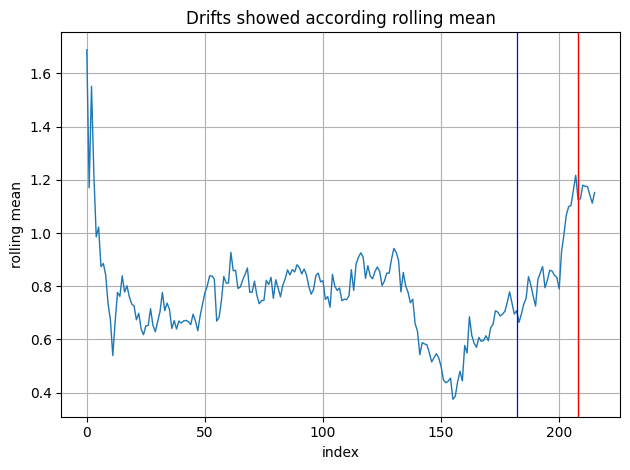

In [ ]:
files = get_file_names()
stream = []
for file in files:
    stream.append(pd.read_csv(file)['Logits_Negative'])
stream = pd.concat(stream, ignore_index=True)


rolling_mean = stream.rolling(len(stream)//10, min_periods=0).mean()

# plt.figure(figsize=(5,3.5))
plt.plot(rolling_mean, linewidth=1)

for m in methods_drifts:
    # if m != 'page hinkley':
    #     continue
    for d in methods_drifts[m]:
        plt.axvline(x = d, color = methods_colors[m], linewidth=0.9, label=m)




plt.title('Drifts showed according rolling mean')
# plt.legend()
plt.xlabel('index')
plt.ylabel('rolling mean')
plt.grid(True)
plt.tight_layout()
plt.show()